In [1]:
import pandas as pd
import plotly.express as px
import torch
from einops import rearrange
import torch
import tqdm

In [2]:
from mamba_lens import HookedMamba
model = HookedMamba.from_pretrained("state-spaces/mamba-370m", device='cuda')
torch.set_grad_enabled(False)

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Moving model to device:  cuda


In [80]:
def get_pad_token(tokenizer):
    return model.tokenizer.encode(model.tokenizer.pad_token, add_special_tokens=False)[0]

# given data that is [N,V] and indicies that are [N,K] with each index being an index into the V space
# this does what you'd want, it indexes them
# idk, see the test
def index_into(data, indices):
    num_data, num_per_data = indices.size()
    # we want
    # [0,0,0,...,] num per data of these
    # [1,1,1,...,] num per data of these
    # ...
    # [num_data-1, num_data-1, ...]
    first_axis_index = torch.arange(num_data, dtype=torch.long).view(num_data, 1)*torch.ones([num_data, num_per_data], dtype=torch.long)
    # now we flatten it so it has an index for each term aligned with our indices
    first_axis_index = first_axis_index.flatten()

    second_axis_index = indices.flatten()
    # now we can just index, and then view back to our original shape
    return data[first_axis_index, second_axis_index].view(num_data, num_per_data)
    

def eval_debug(model, data, correct, incorrect, constrain_to_answers, **kwargs):
    for data_i in range(correct.size()[0]):
        input = model.tokenizer.decode(data[data_i])
        top_k = 2
        logits = model.forward(input, **kwargs)[0,-1]
        correct_answers = correct[data_i]
        incorrect_answers = incorrect[data_i]
        if constrain_to_answers:
            only_consider_answer_logits = torch.full(logits.size(), fill_value=-torch.inf, device=model.cfg.device)
            only_consider_answer_logits[correct_answers] = logits[correct_answers]
            only_consider_answer_logits[incorrect_answers] = logits[incorrect_answers]
            logits = only_consider_answer_logits
        prs = torch.nn.functional.softmax(logits, dim=0)
        top = torch.argsort(-logits)[:top_k]
        printed = False
        printed_prompt = False
        for i, tok in enumerate(top):
            if not i == 0 and tok in correct_answers:
                if not printed_prompt:
                    print("prompt", input)
                    printed_prompt = True
                print(f"  correct top {i} token {repr(model.tokenizer.decode([tok]))} logit {logits[tok]} prs {prs[tok]}")
                printed = True
                #print("correct")
                #print(f"token {model.tokenizer.decode([tok])} logit {logits[tok]} prs {prs[tok]}")
            elif i == 0 and not tok in correct_answers:
                if not printed_prompt:
                    print("prompt", input)
                    printed_prompt = True
                print(f"  incorrect top {i} token {repr(model.tokenizer.decode([tok]))} logit {logits[tok]} prs {prs[tok]}")
                printed = True
            if tok in correct_answers:
                break
        if printed:
            print()

def eval(model, data, correct, incorrect, constrain_to_answers, **kwargs):
        num_examples = correct.size()[0]
        logits = model(data, **kwargs)[:,-1]
        pad = get_pad_token(tokenizer=model.tokenizer)
        logits[:,pad] = -torch.inf # manually set pad pr to -inf logit because sometimes we need to pad num correct or num incorrect

        n_data, n_correct = correct.size()
        n_data, n_incorrect = incorrect.size()

        if constrain_to_answers:
            # [n_data, n_correct]
            correct_logits = index_into(logits, correct)
            # [n_data, n_incorrect]
            incorrect_logits = index_into(logits, incorrect)
            # [n_data, n_correct + n_incorrect]
            combined_logits = torch.concatenate([correct_logits, incorrect_logits], dim=1)
            combined_prs = torch.softmax(combined_logits, dim=1)
            biggest = torch.argsort(-combined_prs, dim=1)
            # if biggest pr is in the correct, we are correct, otherwise, we are not
            num_correct = torch.sum(biggest[:,0] < n_correct)
    
            correct_prs, incorrect_prs = combined_prs.split([n_correct, n_incorrect], dim=1)
        else:
            prs = torch.nn.functional.softmax(logits, dim=1)
            # [n_data, n_correct]
            correct_prs = index_into(prs, correct)
            # [n_data, n_incorrect]
            incorrect_prs = index_into(prs, incorrect)
            # [n_data, 1]
            top_tokens = torch.topk(logits, 1, dim=1).indices
            # [n_data, n_correct]
            in_correct = top_tokens == correct
            # [n_data]
            has_any_correct = torch.any(in_correct, dim=1)
            # [1]
            num_correct = torch.sum(has_any_correct)
    
        # the sum(dim=1) is because we or of all the different possible probabilities by summing
        # then we'll just report the average
        return torch.mean(correct_prs.sum(dim=1)).item(), torch.mean(incorrect_prs.sum(dim=1)).item(), num_correct.item()/float(n_data)
    
    
        # doing this doesn't work because they get too small and numerical precision issues
        # instead we should softmax over the restricted logits
        '''
        prs = torch.nn.functional.softmax(logits, dim=1)
        #for i in range(tops.size()[0]):
        #    print(model.to_str_tokens([tops[i,0]]), tops[i,0], logits[i, tops[i,0]], prs[i, tops[i,0]])
        #    break
        # [n_data, n_correct]
        correct_prs = index_into(prs, correct)
        # [n_data, n_incorrect]
        incorrect_prs = index_into(prs, incorrect)
        # [n_data, 1]
        total_prs = correct_prs.sum(dim=1, keepdim=True)+incorrect_prs.sum(dim=1, keepdim=True)
        total_prs[total_prs == 0] = 1.0
        correct_prs /= total_prs
        incorrect_prs /= total_prs

        # [n_data, n_correct + n_incorrect]
        combined = torch.concatenate([correct_prs, incorrect_prs], dim=1)
        biggest = torch.argsort(-combined, dim=1)
        n_data, n_correct = correct.size()
        # if biggest pr is in the correct, we are correct, otherwise, we are not
        num_correct = torch.sum(biggest[:,0] < n_correct)
        print(biggest[:0])
        print(combined[3:5])
        '''

def add_padding_answers(tokenizer, answers):
    longest_len = len(max(answers, key=lambda x: len(x)))
    padded_answers = []
    pad_token = get_pad_token(tokenizer=tokenizer)
    for answer in answers:
        padded_answers.append(answer + [pad_token]*(longest_len-len(answer)))
    return padded_answers

def get_batched_data(data):
    batched_data = []
    batched_correct = []
    batched_incorrect = []
    
    for i, (prompt, corrects, incorrects) in enumerate(data):
        if i < 3:
            print(prompt, corrects, incorrects)
        batched_data.append(torch.tensor(model.tokenizer.encode(prompt), device=model.cfg.device))
        batched_correct.append([model.tokenizer.encode(correct)[0] for correct in corrects])
        batched_incorrect.append([model.tokenizer.encode(incorrect)[0] for incorrect in incorrects])
    try:
        batched_data = torch.stack(batched_data)
        batched_correct = torch.tensor(add_padding_answers(tokenizer=model.tokenizer, answers=batched_correct), device=model.cfg.device)
        batched_incorrect = torch.tensor(add_padding_answers(tokenizer=model.tokenizer, answers=batched_incorrect), device=model.cfg.device)
    except RuntimeError:
        typical_len = len(batched_data[0])
        for s in batched_data:
            if not len(s) == typical_len:
                print(len(s), "is len of this, typical len is", typical_len, "for sequence", model.to_str_tokens(s))
        raise
    return batched_data, batched_correct, batched_incorrect

def bar_chart(data, x_labels, y_label, title, font_size=None):
    # it requires a pandas dict with the columns and rows named, annoying
    # by default rows and columns are named with ints so we relabel them accordingly
    renames = dict([(i, x_labels[i]) for i in range(len(x_labels))])
    ps = pd.DataFrame(data.cpu().numpy()).rename(renames, axis='rows').rename({0: y_label}, axis='columns')
    fig = px.bar(ps, y=y_label, x=x_labels, title=title)
    if not font_size is None:
        fig.update_layout(
          xaxis = dict(
            tickmode='array',
            tickvals = x_labels,
            ticktext = x_labels, 
            ),
           font=dict(size=font_size, color="black"))
        
        #fig.update_xaxes(title_font=dict(size=font_size))
    
    fig.show()

In [114]:
## Generate data

from docstring import docstring_prompt_generator_function
from importlib import reload
import test_data
reload(test_data)
from test_data import IOI_generator, BABA_TEMPLATES, greater_than_data_generator, ABC_TEMPLATES, copy_generator

out_acc = torch.zeros([model.cfg.n_layers], device=model.cfg.device)
out_prs_correct = torch.zeros([model.cfg.n_layers], device=model.cfg.device)
out_prs_incorrect = torch.zeros([model.cfg.n_layers], device=model.cfg.device)

num_examples = 100

seed = 27
valid_seed = 37
test_seed = 47

data_type = 'copy'

constrain_to_answers = True

if data_type == 'ioi':
    data = IOI_generator(templates=[BABA_TEMPLATES[1]], tokenizer=model.tokenizer, num_examples=num_examples, symmetric=True, seed=seed)
    valid_data = IOI_generator(templates=[BABA_TEMPLATES[1]], tokenizer=model.tokenizer, num_examples=num_examples, symmetric=True, seed=valid_seed)
    test_data = IOI_generator(templates=[BABA_TEMPLATES[1]], tokenizer=model.tokenizer, num_examples=num_examples, symmetric=True, seed=test_seed)
elif data_type == 'docstring':
    data = docstring_prompt_generator_function(tokenizer=model.tokenizer, num_examples=num_examples, corrupt='random_answer', seed=seed)
    valid_data = docstring_prompt_generator_function(tokenizer=model.tokenizer, num_examples=num_examples, corrupt='random_answer', seed=valid_seed)
    test_data = docstring_prompt_generator_function(tokenizer=model.tokenizer, num_examples=num_examples, corrupt='random_answer', seed=test_seed)
elif data_type == 'greater than':
    constrain_to_answers = False
    data = greater_than_data_generator(tokenizer=model.tokenizer, num_examples=num_examples, seed=seed)
    valid_data = greater_than_data_generator(tokenizer=model.tokenizer, num_examples=num_examples, seed=valid_seed)
    test_data = greater_than_data_generator(tokenizer=model.tokenizer, num_examples=num_examples, seed=test_seed)
elif data_type == 'copy':
    constrain_to_answers = False
    copy_seq_len = 10
    data = copy_generator(tokenizer=model.tokenizer, num_examples=num_examples, copy_seq_len=copy_seq_len, seed=seed)
    valid_data = copy_generator(tokenizer=model.tokenizer, num_examples=num_examples, copy_seq_len=copy_seq_len, seed=valid_seed)
    test_data = copy_generator(tokenizer=model.tokenizer, num_examples=num_examples, copy_seq_len=copy_seq_len, seed=test_seed)

print("data")
batched_data, batched_correct, batched_incorrect = get_batched_data(data)
print("\n\nvalid\n")
vbatched_data, vbatched_correct, vbatched_incorrect = get_batched_data(valid_data)
print("\n\ntest")
tbatched_data, tbatched_correct, tbatched_incorrect = get_batched_data(test_data)



data
 hockeySEQUENTIAL polyratingraised unsupported petty130 marchinginguish hockeySEQUENTIAL polyratingraised unsupported petty130 marching ['inguish'] ['<|endoftext|>']
 CCA mellitus Sitrail )"Mut subsets milliseconds Anglo ------------------------- CCA mellitus Sitrail )"Mut subsets milliseconds Anglo [' -------------------------'] ['<|endoftext|>']
 Troydatepicker explosionipation consultingattentionhengmaleBritish pumps Troydatepicker explosionipation consultingattentionhengmaleBritish [' pumps'] ['<|endoftext|>']


valid

anciesellarUsedrewpackage) make bodiesSR AREanciesellarUsedrewpackage) make bodiesSR [' ARE'] ['<|endoftext|>']
 dreaming tuition shedolutecoupled*\<857 dreaming tuition shedolutecoupled*\< ['857'] ['<|endoftext|>']
 postal Romanian encountered neurologicalAndersonformance  immunosupp postal Romanian encountered neurologicalAndersonformance  immunos ['upp'] ['<|endoftext|>']


test
RegisterCALeda Milk Solid)]{} alignovirus fringe
RegisterCALeda Milk Solid)]{} al

In [ ]:
## Run the layer removal experiments
pr_is_relative = constrain_to_answers
relative_str = ' relative ' if constrain_to_answers else ' '

print(f"constraining output to answers? {constrain_to_answers}")

history = []
history_stats = []
layers_to_remove = []
while len(layers_to_remove) < model.cfg.n_layers:
    base_layers = list(range(model.cfg.n_layers))


    for layer in layers_to_remove:
        base_layers.remove(layer)
    history.append(list(base_layers))
    
    correct, incorrect, acc = eval(model, vbatched_data, vbatched_correct, vbatched_incorrect,
                                      only_use_these_layers=base_layers, fast_ssm=True, fast_conv=True,
                                      constrain_to_answers=constrain_to_answers)
    print(f"correct{relative_str}pr {correct} incorrect{relative_str}pr {incorrect} accuracy {acc}")
    history_stats.append((correct, incorrect, acc))
    print(base_layers)
    
    for i, start_layer in tqdm.tqdm(enumerate(base_layers)):
        #layers = list(range(start_layer, end_layer+1))
        layers = list(base_layers)
        layers.remove(start_layer)

        
        correct, incorrect, acc = eval(model, batched_data, batched_correct, batched_incorrect,
                                      only_use_these_layers=layers, fast_ssm=True, fast_conv=True,
                                      constrain_to_answers=constrain_to_answers)
        out_prs_correct[i] = correct
        out_prs_incorrect[i] = incorrect
        out_acc[i] = acc
        
    
    best_layer_to_remove = base_layers[torch.argsort(-out_acc[:len(base_layers)])[0]]
    print("removing layer", best_layer_to_remove)
    layer_names = [f'layer {x}' for x in base_layers]
    layers_to_remove.append(best_layer_to_remove)

history_stats = torch.tensor(history_stats)

constraining output to answers? False
correct pr 0.5844205021858215 incorrect pr 0.0 accuracy 0.9
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


48it [00:14,  3.40it/s]


removing layer 1
correct pr 0.6032507419586182 incorrect pr 0.0 accuracy 0.9
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


47it [00:13,  3.45it/s]


removing layer 14
correct pr 0.5890081524848938 incorrect pr 0.0 accuracy 0.89
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


46it [00:13,  3.52it/s]


removing layer 15
correct pr 0.5987220406532288 incorrect pr 0.0 accuracy 0.9
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


45it [00:12,  3.59it/s]


removing layer 4
correct pr 0.5875974893569946 incorrect pr 0.0 accuracy 0.89
[0, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


44it [00:12,  3.67it/s]


removing layer 7
correct pr 0.6008096933364868 incorrect pr 0.0 accuracy 0.88
[0, 2, 3, 5, 6, 8, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


43it [00:11,  3.75it/s]


removing layer 8
correct pr 0.5745116472244263 incorrect pr 0.0 accuracy 0.88
[0, 2, 3, 5, 6, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


42it [00:10,  3.83it/s]


removing layer 3
correct pr 0.5519867539405823 incorrect pr 0.0 accuracy 0.87
[0, 2, 5, 6, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


41it [00:10,  3.92it/s]


removing layer 6
correct pr 0.5468150973320007 incorrect pr 0.0 accuracy 0.89
[0, 2, 5, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


40it [00:09,  4.01it/s]


removing layer 16
correct pr 0.5567450523376465 incorrect pr 0.0 accuracy 0.86
[0, 2, 5, 9, 10, 11, 12, 13, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


18it [00:04,  4.12it/s]

In [81]:
# pick something from the above output to test on an held out test set
# [0, 9, 10, 11, 14, 16, 19, 22, 33, 39] is from ABC_TEMPLATES
# [0, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 40, 41, 44, 45] docstring
# [0, 9, 11, 12, 16, 18, 19, 20, 22, 23, 24, 25, 26, 29, 31, 33, 34, 36, 40, 41, 42, 45, 46, 47]
print(f"constraining output to answers? {constrain_to_answers}")
test_layers = [0, 9, 11, 12, 16, 18, 19, 20, 22, 23, 24, 25, 26, 29, 31, 33, 34, 36, 40, 41, 42, 45, 46, 47]
correct, incorrect, acc = eval(model, tbatched_data, tbatched_correct, tbatched_incorrect,
                                  only_use_these_layers=test_layers, fast_ssm=True, fast_conv=True,
                                      constrain_to_answers=constrain_to_answers)
print()
print(f"test set eval results: correct{relative_str}pr {correct} incorrect{relative_str}pr {incorrect} accuracy {acc}")
print()
eval_debug(model=model,
           data=tbatched_data, correct=tbatched_correct, incorrect=tbatched_incorrect,
           constrain_to_answers=constrain_to_answers,
           only_use_these_layers=test_layers, fast_ssm=True, fast_conv=True)


constraining output to answers? False

test set eval results: correct pr 0.6495634317398071 incorrect pr 0.13873164355754852 accuracy 0.92

prompt The employment lasted from the year 1332 to 13
  incorrect top 0 token '33' logit -0.8503713607788086 prs 0.05978742986917496

prompt The impact lasted from the year 1748 to 17
  incorrect top 0 token ',' logit -7.7801666259765625 prs 0.06563079357147217

prompt The reforms lasted from the year 1796 to 17
  incorrect top 0 token '99' logit 14.66119384765625 prs 0.23021537065505981
  correct top 1 token '98' logit 14.575467109680176 prs 0.2113020271062851

prompt The agreement lasted from the year 1112 to 11
  incorrect top 0 token '.' logit -14.291669845581055 prs 0.10757892578840256

prompt The marriage lasted from the year 1271 to 12
  incorrect top 0 token '.' logit -10.621082305908203 prs 0.19373463094234467
  correct top 1 token '72' logit -11.124336242675781 prs 0.11712425947189331

prompt The raids lasted from the year 1720 to 17
  in

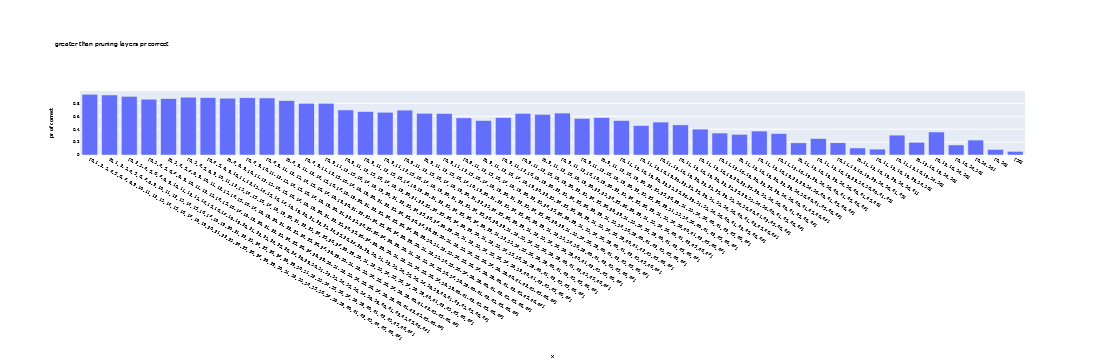

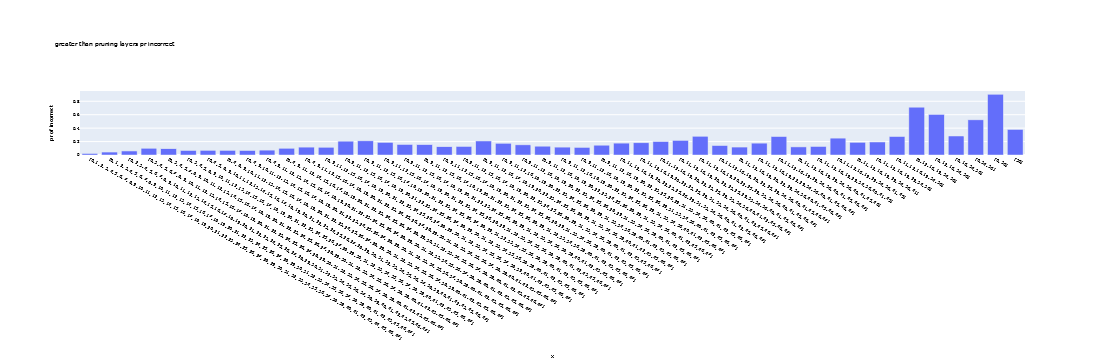

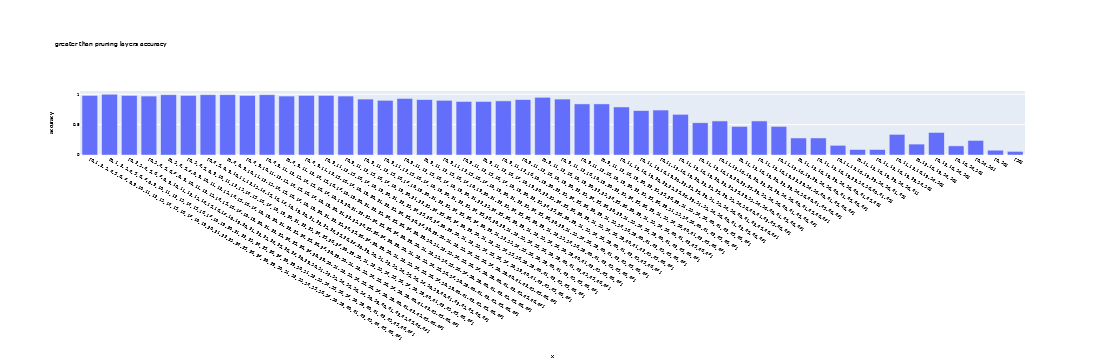

In [83]:
bar_chart(history_stats[:,0], x_labels=[str(x) for x in history], y_label=f'{relative_str}pr of correct', title=f"{data_type} pruning layers{relative_str}pr correct", font_size=4)
bar_chart(history_stats[:,1], x_labels=[str(x) for x in history], y_label=f'{relative_str}pr of incorrect', title=f"{data_type} pruning layers{relative_str}pr incorrect", font_size=4)
bar_chart(history_stats[:,2], x_labels=[str(x) for x in history], y_label='accuracy', title=f"{data_type} pruning layers accuracy", font_size=4)





